# McNulty Modeling - Parametric Models


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer

from sklearn import svm

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib as mpl
import scipy.stats as st

from imblearn.over_sampling import RandomOverSampler

import pickle
from collections import Counter

In [6]:
# Get pickles for new league dfs
with open('sc_newLeagues_scaled.pickle','rb') as read_file:
    scs = pickle.load(read_file)

# Pickle opening code
with open('sc_newLeagues_noscale.pickle','rb') as read_file:
    scns = pickle.load(read_file)

### Confusion Matrix Function

In [38]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), 
                           labelsize=18, fontsize=15, numsize=20, cmap=None, cbar_size=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": numsize}, 
                              cmap=cmap )
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=labelsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=labelsize)
    plt.ylabel('TRUE', fontsize=fontsize)
    plt.xlabel('PREDICTED', fontsize=fontsize)
    return fig

## Create DF Variants for Modeling

#### Target = LeagueIndex

In [8]:
# Our target across all models
y = scs['LeagueIndex']

### Parametric Model Features
Very few due to general lack of normality in the dataset
- APM
- NumberOfPACs
- UniqueUnitsMade

In [9]:
# Unscaled parametric features
par_noscal = scns.copy()
par_noscal = par_noscal[['APM', 'NumberOfPACs', 'UniqueUnitsMade']]

In [10]:
# Scaled parametric features
par_scaled = scs.copy()
par_scaled = par_scaled[['APM', 'NumberOfPACs', 'UniqueUnitsMade']]

### Custom Recall Scorer

In [16]:
# Make custom scorer
recallScorer = make_scorer(metrics.recall_score, average=None, labels=[3])

## Parametric Approach
This may have a tougher time due to the general lack of normality in the dataset. Only three features survived the normality/collinearity culling. 
- Logistic Regression
    - We'll start out with an oversample of the the parametric dataset, since it worked out well for previous models.

In [11]:
# New train_test_split for scaled dataset with only parametric features 
X_train, X_test, y_train, y_test = train_test_split(par_scaled, y, test_size=0.25, random_state=42)

In [12]:
# Oversample the classes
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

### Logistic Regression with GridSearchCV

In [13]:
logistic_grid = {'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00005, 0.00001, 0.000001, 1e-07],
                 'penalty': ['l2'],
                 'multi_class': ['multinomial'],
                 'solver': ['newton-cg', 'lbfgs', 'sag'],
                 'max_iter': [500]}

In [14]:
log_reg_clf = LogisticRegression()

In [17]:
log_model = GridSearchCV(estimator = log_reg_clf, param_grid = logistic_grid, 
                              cv = 5, verbose=2, n_jobs = -1, scoring=recallScorer)
log_model.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:    2.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 5e-05, 1e-05, 1e-06, 1e-07], 'penalty': ['l2'], 'multi_class': ['multinomial'], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score, average=None, labels=[3]),
       verbose=2)

In [18]:
# Print optimized scores
print('Best score for Logistic Regression:', log_model.best_score_)
print('Best Estimator:', log_model.best_estimator_.C)
print('Best Solver:', log_model.best_estimator_.solver)

Best score for Logistic Regression: 0.8572635135135135
Best Estimator: 1e-06
Best Solver: lbfgs


- Extremely low hyperparameter value at C=1e-06. May indicate something interesting going on with the data. 
- Test score is good. Let's see how it performs on test.

# Train on the optimized parameters


In [19]:
log_best=LogisticRegression(C=1e-06, penalty='l2', multi_class='multinomial', solver='lbfgs',
                            max_iter=500)
log_best.fit(X_resampled, y_resampled)
y_pred=log_best.predict(X_test)

### GridSearchCV Optimized Logistic Regression Test Score

In [20]:
print("Accuracy Score:", metrics.accuracy_score(y_test, y_pred))
print("Overall Recall:" , metrics.recall_score(y_test, y_pred, average=None))
print("Contender Class Recall:" , metrics.recall_score(y_test, y_pred, average=None, labels=[3]))

Accuracy Score: 0.4677804295942721
Overall Recall: [0.88888889 0.02926829 0.88622754]
Contender Class Recall: [0.88622754]


In [21]:
#print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), labelsize=18, fontsize=15, cmap=None)

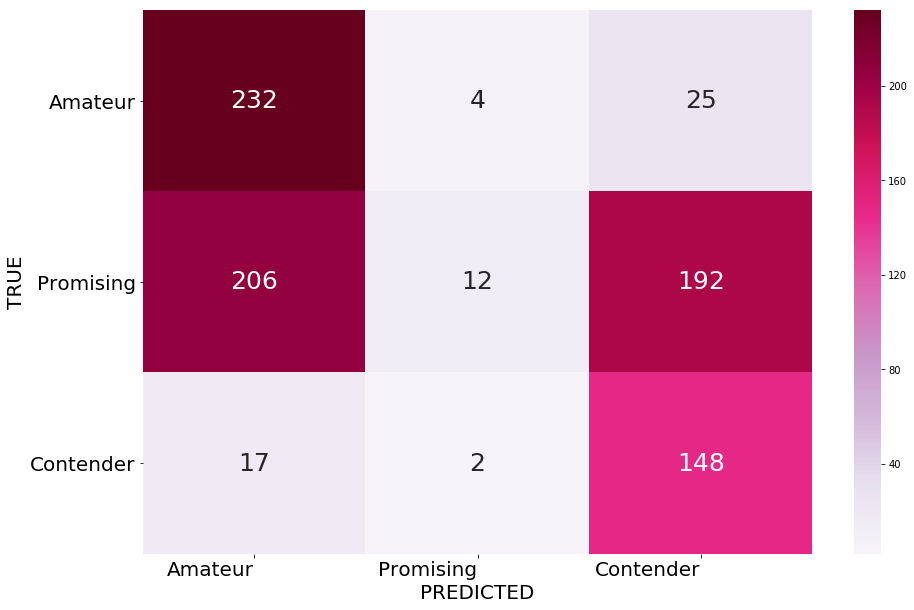

In [40]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cm = print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Amateur', 'Promising', 'Contender'], 
                           figsize = (15,10), cmap='PuRd', labelsize=20, fontsize=20, numsize=25)

- Very interesting final result here. The __the prediciton for Contender is highest with Logistic Regression__, but the predicion for Promising is abyssmal. 
- While I like the more inclusive nature for Contender, in that we aren't missing any, this is probably not the best score overall, due to the extremely poor performance for Promising. 